In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yaml
from collections import defaultdict
import pprint

### Import column dictionary from yaml

The yaml file has information regarding the data in the following form:

  ```
  dictionary:
      school.name:
        source: INSTNM
        type: autocomplete
        description: Institution name
        index: fulltext 
  ```
The type indicates the data type and should be indicated when reading in the college scorecard csv.  
Null values are written as ```NULL``` or ```PrivacySupressed```.   
The dictionary is nested. For the example above, the ```school.name``` key returns four more keys ```source, type, description, index```. Each of those keys returns a value. The colum name is under the nested key ```source```. It needs to be flipped so that the value of ```source``` is the main key.

In [86]:
yaml_file = open("data.yaml", 'r')
yaml_content = yaml.load(yaml_file)

## Need to flip the dictionary so that the the keys match the column names
flippeddict = defaultdict(dict)
try:
    for key, val in yaml_content["dictionary"].items():
        newkey = val['source']
        for subkey, subval in val.items():
            flippeddict[newkey][subkey] = subval
except KeyError:
    pass

# pprint.pprint(dict(flippeddict))

<ipython-input-86-4fce6df8588d>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_content = yaml.load(yaml_file)


*Work in progress, defining columns of interest*

In [164]:
cols_of_interest = ['INSTNM',  
                    'COSTT4_A', 'COSTT4_P', 'DEBT_MDN','MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10','TUITFTE', 'AVGFACSAL', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'ACTCM25', 
                    'ACTCM75', 'UGDS', 'UG25ABV', 'PCTFLOAN', 'CDR3' ]
cols_numeric = ['COSTT4_A', 'COSTT4_P', 'DEBT_MDN','MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10','TUITFTE', 'AVGFACSAL', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'ACTCM25', 
                    'ACTCM75', 'UGDS', 'UG25ABV', 'PCTFLOAN', 'CDR3' ]

# Import data

First a function is defined to read and merge csv files. Next the fucntion is run from the year 1996-2020.   
<div class="alert-danger">
To do: use yaml file to pipe in dtypes for each column
</div>

In [148]:
# Define a function read and merge all years
def read_cs_data(year,datadir):
    """read a CollegeScorecard dataframe"""
    nextyr = str(int(year) + 1)[-2:]
    filename = datadir + '/MERGED{}_{}_PP.csv'.format(year,nextyr)
    
    # Specify dtype because guessing dtypes is very memory intensive
    # Specify that "PrivacySuppressed" are NaN values
    # Eventually can use usecols to specify which columns of interest to import
    col = pd.read_csv(filename, dtype='unicode',na_values='PrivacySuppressed') 
    col['Year'] = pd.Period(str(int(year) + 1),freq='Y')
    return col

In [280]:
datadir = "/Users/jhuang/DS4A/CollegeScorecard_Raw_Data_08032021"
df = pd.concat((read_cs_data(str(y),datadir) for y in range(2000,2015)))
df = df.set_index(['UNITID','Year'])
# df_subset = df[cols_of_interest]

KeyboardInterrupt: 

In [92]:
df.head()

,UNITID,Year,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,...,FEDSCHCD,BOOKSUPPLY,ROOMBOARD_ON,OTHEREXPENSE_ON,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,DOLPROVIDER
0,100636,1997,01230800,012308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100654,1997,00100200,001002,Alabama A & M University,Normal,AL,35762,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100663,1997,00105200,001052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100672,1997,00574900,005749,ALABAMA AVIATION AND TECHNICAL COLLEGE,OZARK,AL,36360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100690,1997,02503400,025034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save merged csv to disk

Next time, this merged csv can be read directly to skip the time-consuming step of reading each year separately.

In [150]:
df.to_csv('ALLMERGED.csv') # Export to csv

In [236]:
## Use this to read in merged csv directly
df = pd.read_csv('ALLMERGED.csv', dtype='unicode',na_values='PrivacySuppressed') 

# Data cleaning

To begin, columns with more than 60% ```NaN``` values are omitted. This can percentage can be changed in the code. Three variables related to earnings post-graduation are added back in, ```MN_EARN_WNE_P6,MN_EARN_WNE_P8,MN_EARN_WNE_P10```. There are likely more that can be added back easily.

### Dropping columns with too many ```NaN```

In [174]:
# Function to get a table of missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [175]:
mis_val = missing_values_table(df)
mis_val.head()

Your selected dataframe has 2393 columns.
There are 2381 columns that have missing values.


,Missing Values,% of Total Values
ACCREDAGENCY,163332,100.0
DTRANS_4_POOLED,163332,100.0
D100_4_POOLED,163332,100.0
C100_L4_POOLED,163332,100.0
C100_4_POOLED,163332,100.0


In [237]:
# Drop columms with more than 60% NaN
df_dropna = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)

# Add back in certain columns
cols_to_add = ['MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10']
for col in cols_to_add:
    df_dropna[col] = df[col]

<ipython-input-237-056a24831277>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna[col] = df[col]


In [238]:
print("Shape before:", df.shape, " Shape after:", df_dropna.shape)

Shape before: (163332, 2393)  Shape after: (163332, 350)


Drop columns ending in ```ASSOC, CERT1, CERT2, CERT4, BACHL```. These correspond to whether an institution offers bachelors, associate degree, and diploma for 1, 2, and 4 years in the program.

In [239]:
df_drop2 = df_dropna.loc[:, ~df_dropna.columns.str.endswith('ASSOC')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT2')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT1')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT4')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.startswith('BACHL')] #PCIP

In [240]:
print("Shape before:", df_dropna.shape, " Shape after:", df_drop2.shape)

Shape before: (163332, 350)  Shape after: (163332, 198)


### Sum fields of studies into broader categories

Here the ```PCIP``` variables are used, which represent percentage of students in a specific field 

In [275]:
df_drop3 = df_drop2.copy()

### Clumping fields of studies into broad categories

In [276]:
natresources = ['PCIP01','PCIP03','PCIP31']
social = ['PCIP05','PCIP09','PCIP13','PCIP19','PCIP22','PCIP30','PCIP44','PCIP45','PCIP51']
stem = ['PCIP04','PCIP11','PCIP14','PCIP15','PCIP26','PCIP27','PCIP29','PCIP40','PCIP41','PCIP42','PCIP47']
humanities = ['PCIP16','PCIP23','PCIP24','PCIP38','PCIP39','PCIP50','PCIP54']
techtrade = ['PCIP10','PCIP12','PCIP25','PCIP43','PCIP46','PCIP48','PCIP49']
business = ['PCIP52']

def sumcols(df, columns, summedcolname):
    for col in columns:
        df[col] = df[col].astype(float)

    df[summedcolname] = df[columns].sum(axis=1)

sumcols(df_drop3,natresources,"Field_NR")
sumcols(df_drop3,social,"Field_social")
sumcols(df_drop3,stem,"Field_STEM")
sumcols(df_drop3,humanities,"Field_AH")
sumcols(df_drop3,techtrade,"Field_techtrade")
sumcols(df_drop3,business,"Field_bus")

In [279]:
df_drop3.head()
df_drop3.sort_values(by='Field_STEM', ascending=False)["Field_STEM"]

,UNITID,Year,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,...,UG12MN,MN_EARN_WNE_P6,MN_EARN_WNE_P8,MN_EARN_WNE_P10,Field_NR,Field_social,Field_STEM,Field_AH,Field_techtrade,Field_bus
0,100636,1997,01230800,012308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,1,...,69611,NaN,NaN,NaN,0.0035,0.2168,0.4265,0.0050,0.1489,0.1994
1,100654,1997,00100200,001002,Alabama A & M University,Normal,AL,35762,NaN,1,...,4441,NaN,NaN,NaN,0.0646,0.3074,0.3498,0.0153,0.0390,0.2241
2,100663,1997,00105200,001052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,1,...,14045,NaN,NaN,NaN,0.0000,0.4492,0.2474,0.0950,0.0450,0.1632
3,100672,1997,00574900,005749,ALABAMA AVIATION AND TECHNICAL COLLEGE,OZARK,AL,36360,NaN,1,...,490,NaN,NaN,NaN,0.0000,0.0000,0.9180,0.0000,0.0821,0.0000
4,100690,1997,02503400,025034,Amridge University,Montgomery,AL,36117-3553,NaN,1,...,115,NaN,NaN,NaN,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [303]:
df_drop3["TUITFTE"] = df_drop3["TUITFTE"].astype(float)
df_drop3.loc[~(df_drop3['TUITFTE'] > 1), 'TUITFTE']=np.nan

### Exploratory data analysis: some plots

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


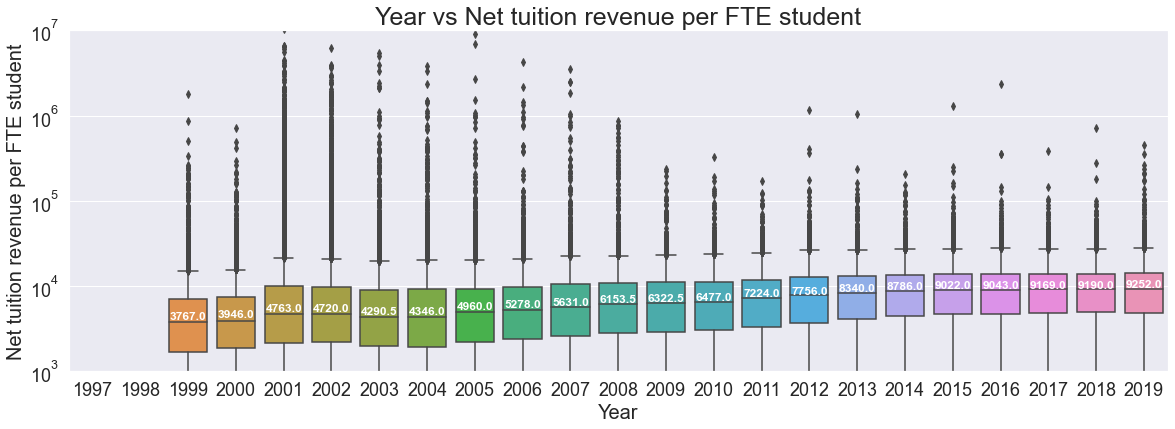

In [365]:
# Boxplot of TUITFTE over the years
ax = sns.boxplot(x="Year", y="TUITFTE", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
ax.set(yscale="log")
ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Net tuition revenue per FTE student",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Net tuition revenue per FTE student', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['TUITFTE'].median()
vertical_offset = df_drop3['TUITFTE'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_TUITFTE.png')

In [341]:
df_drop3.sort_values(by='TUITFTE', ascending=False)["TUITFTE"]

47536     26670163.0
27848     11932462.0
28728     10414750.0
58965      8969462.0
60579      7014195.0
             ...    
163327           NaN
163328           NaN
163329           NaN
163330           NaN
163331           NaN
Name: TUITFTE, Length: 163332, dtype: float64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

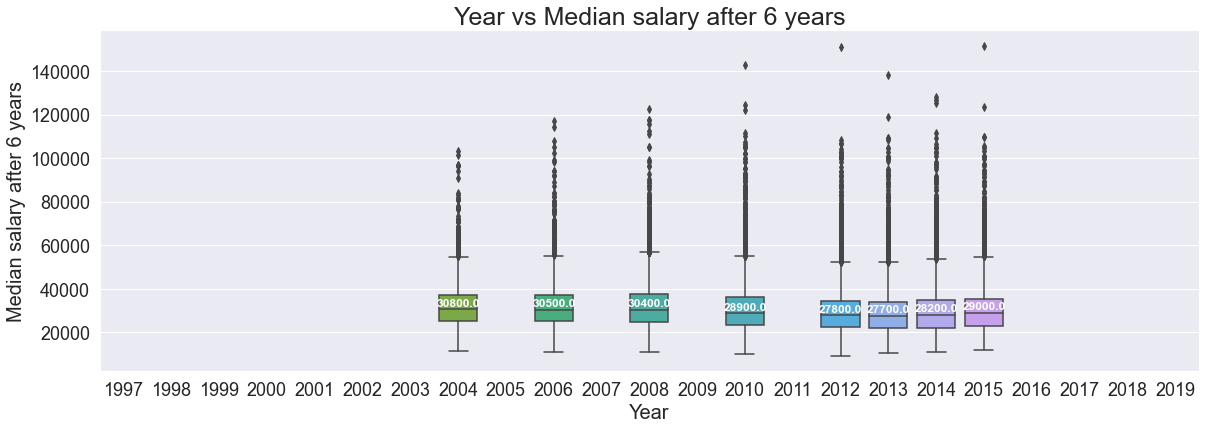

In [366]:
# Boxplot of MN_EARN_WNE_P6 over the years
df_drop3["MN_EARN_WNE_P6"] = df_drop3["MN_EARN_WNE_P6"].astype(float)
ax = sns.boxplot(x="Year", y="MN_EARN_WNE_P6", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
# ax.set(yscale="log")
# ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Median salary after 6 years",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Median salary after 6 years', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['MN_EARN_WNE_P6'].median()
vertical_offset = df_drop3['MN_EARN_WNE_P6'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_MN_EARN_WNE_P6.png')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


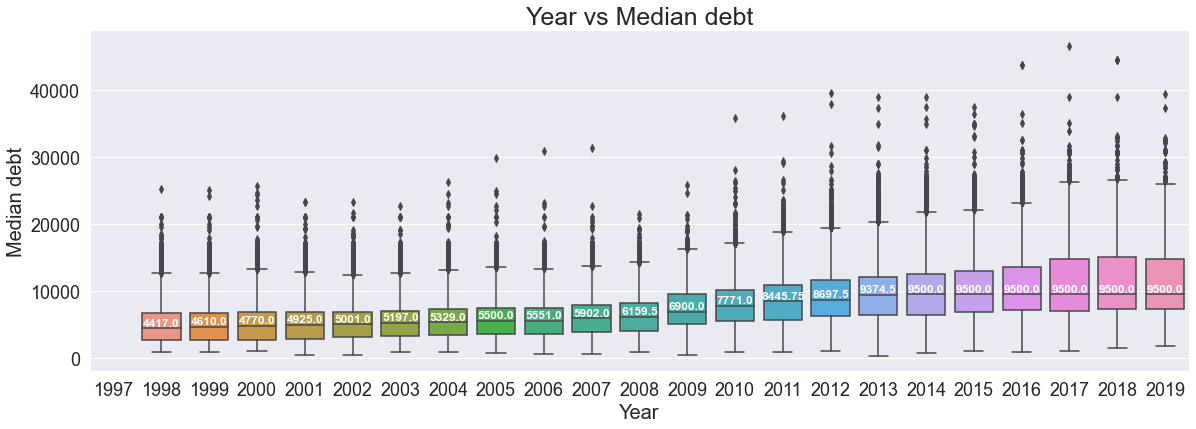

In [364]:
# Boxplot of DEBT_MDN over the years
df_drop3["DEBT_MDN"] = df_drop3["DEBT_MDN"].astype(float)
ax = sns.boxplot(x="Year", y="DEBT_MDN", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
# ax.set(yscale="log")
# ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Median debt",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Median debt', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['DEBT_MDN'].median()
vertical_offset = df_drop3['DEBT_MDN'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_DEBT_MDN.png')


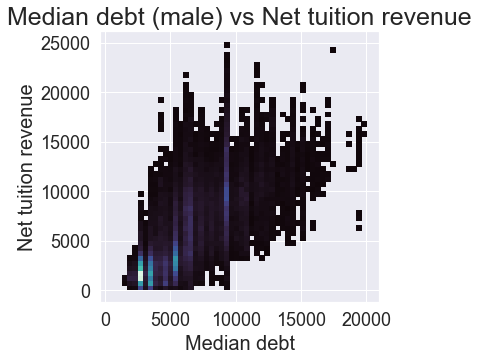

In [389]:
df_drop3["MALE_DEBT_MDN"] = df_drop3["MALE_DEBT_MDN"].astype(float)
df_drop3cut = df_drop3[(df_drop3['TUITFTE'].between(0, 25000)) & (df_drop3["MALE_DEBT_MDN"].between(0, 20000))]
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, y="TUITFTE", x="MALE_DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
# plt.title("Median debt  vs Net tuition revenue")
ax.set_title("Median debt (male) vs Net tuition revenue",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Net tuition revenue', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

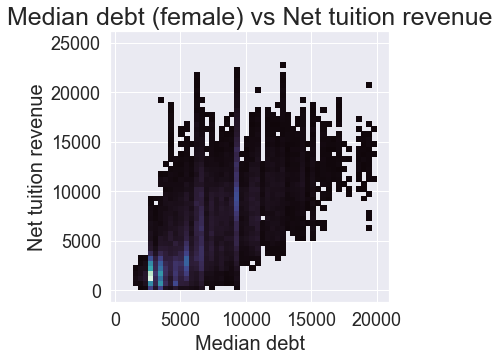

In [390]:
df_drop3["FEMALE_DEBT_MDN"] = df_drop3["FEMALE_DEBT_MDN"].astype(float)
df_drop3cut = df_drop3[(df_drop3['TUITFTE'].between(0, 25000)) & (df_drop3["FEMALE_DEBT_MDN"].between(0, 20000))]
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, y="TUITFTE", x="FEMALE_DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
# plt.title("Median debt vs Net tuition revenue")
ax.set_title("Median debt (female) vs Net tuition revenue",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Net tuition revenue', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

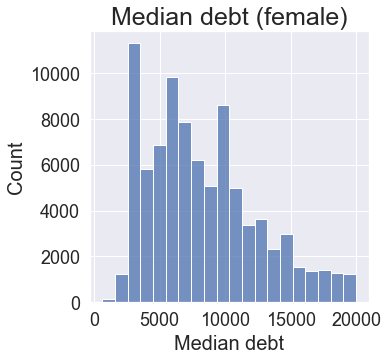

In [418]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, x="FEMALE_DEBT_MDN", bins=20)
sns.set(rc={'figure.figsize':(10,10)})
# plt.title("Median debt vs Net tuition revenue")
ax.set_title("Median debt (female)",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

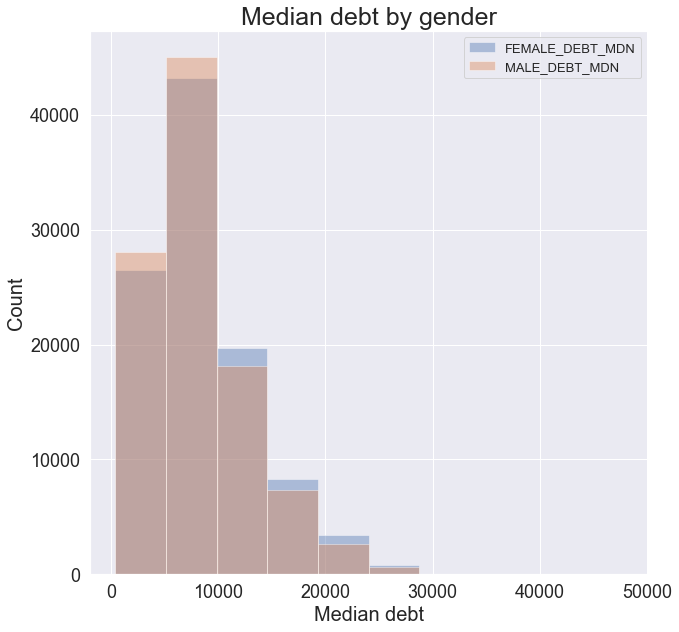

In [419]:
## Median debt by gender
ax = df_drop3[["FEMALE_DEBT_MDN", "MALE_DEBT_MDN"]].plot.hist(alpha=0.4)
ax.set_title("Median debt by gender",fontsize=25)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 13})

ax.get_figure().savefig('debt_by_gender.png')

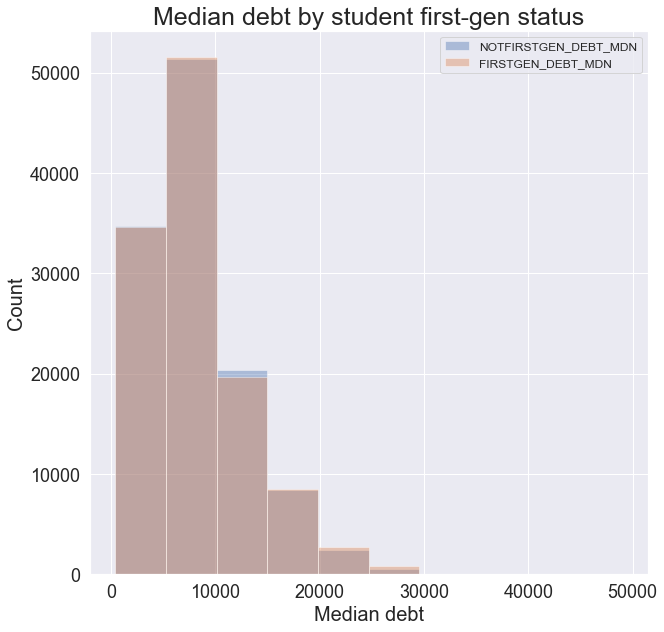

In [420]:
## Median debt by whether or not the student is first-generation
df_drop3["NOTFIRSTGEN_DEBT_MDN"] = df_drop3["NOTFIRSTGEN_DEBT_MDN"].astype(float)
df_drop3["FIRSTGEN_DEBT_MDN"] = df_drop3["FIRSTGEN_DEBT_MDN"].astype(float)
ax = df_drop3[["NOTFIRSTGEN_DEBT_MDN", "FIRSTGEN_DEBT_MDN"]].plot.hist(alpha=0.4)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_title("Median debt by student first-gen status",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 12})

ax.get_figure().savefig('debt_by_1stgen.png')

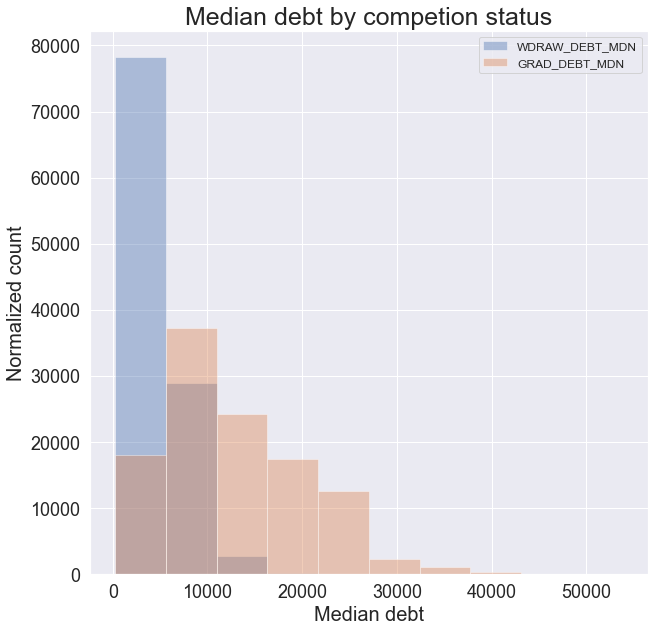

In [425]:
## Median debt by whether or not the student is first-generation
df_drop3["WDRAW_DEBT_MDN"] = df_drop3["WDRAW_DEBT_MDN"].astype(float)
df_drop3["GRAD_DEBT_MDN"] = df_drop3["GRAD_DEBT_MDN"].astype(float)
ax = df_drop3[["WDRAW_DEBT_MDN", "GRAD_DEBT_MDN"]].plot.hist(alpha=0.4)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_title("Median debt by competion status",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Normalized count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 12})

ax.get_figure().savefig('debt_by_completion.png')

Save list of cleaned columns to txt file

In [214]:
# Save list of columns to txt file
myfile = open('CollegeScorecardCleanedColumns.csv', 'w')
for col in df_drop2.columns:
    try:
#         print(col,":", flippeddict[col]["description"])
        var1=col+","+" "+flippeddict[col]["description"]
        myfile.write("%s\n" % var1)
    except KeyError:
        pass
myfile.close()

### Use dictionary from yaml to change column dtypes

Must do this after defining columns of interest. It is too time consuming to do it for the whole dataset.

In [182]:
# Function to set dtypes on columns of interest in a dataframe using the yaml flipped dictionary from
def setdtypes(cols_of_interest, df, flippeddict):
    for col in cols_of_interest:
        print("Doing ",cols_of_interest)
        try:
            if flippeddict[col]["type"] == "integer":
                df[col] = df[col].astype("int")
                print("dtype changed to int.")
            elif flippeddict[col]["type"] == "float":
                df[col] = df[col].astype("float")
                print("dtype changed to float.")
            else:
                pass
        except KeyError:
            print("KeyError, skipping")
            pass
        except ValueError:
            print("ValueError, skipping")
            pass
        
#     print(flippeddict[col])

In [ ]:
# df["ACTCM25"] = df['PCTFLOAN'].astype('float')
# df["ADM_RATE_ALL"].dtypes

# Determining feature importance

Going to try to use some models to determine which features are important. Work in progress.

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer

model=c(random_state=1)
 
features=df
 
model.fit(features,df_dropna['MN_EARN_WNE_P6'])
 
feature_importance=pd.DataFrame({'feature':list(features.columns),'feature_importance':[abs(i) for i in model.coef_[0]]})
feature_importance.sort_values('feature_importance',ascending=False)
 

ValueError: could not convert string to float: '001057A1'

### Plotting stuff

In [ ]:
df_subset = df[cols_of_interest]
for col in cols_numeric:
    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')
df_subset.info()

In [ ]:
sns.histplot(df_subset, y="TUITFTE", x="DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
plt.title("Cost of tuition vs Median earnings after 6 years")